## **Data Analysis**

**Input for our analysis:**
- **Angel - Startup relations**
- **Startup list** including Name, #of angel investors, industry, region
- **Angel list** including #of investments, name, region, average shares, number of investments per industry

**Steps of our analysis:**

1. **Creating a network graph**

2. **Descriptive Statistics** on:
   - _Angels_
   - _Startups_
   - _Network_

3. **Simulating a network graph with Null distribution**

4. **Community detection** in actual and simulated communities

5. **Analysis of similarity of communities** in terms of:
   - _Reach and Power_
   - _Investment Style_
   - _Personal Characteristics_

## Importing libraries and data - 0

In [208]:
#all libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import datetime


In [456]:
#all data sets
#open from csv the shareholder list as a dataframe
def loadData():
    df_investment_rel_angel_startup = pd.read_csv("dataframes/shareholders_list.csv", sep=';')
    #open from csv the shareholders as a dataframe
    df_angels = pd.read_csv("dataframes/shareholders.csv",sep=';')
    #open from csv the startups as a dataframe
    df_startups = pd.read_csv("dataframes/startups.csv",sep=';')
    return df_investment_rel_angel_startup, df_angels, df_startups

In [455]:
#temp mutations, startup df
#rename counts to number_of_investors

def mutateStartups(df_startups):
    df_startups.rename(columns={'counts':'number_of_investors'}, inplace=True)

    #add column number of angels and assign random value
    df_startups['number_of_angels'] = np.random.randint(1, 4, df_startups.shape[0])

    #add column number of active angel investors and assign random value
    df_startups['number_of_active_angels'] = np.random.randint(1, 4, df_startups.shape[0])

    categories = [
        "technology_digital_services",
        "production_trade",
        "energy_environment_infrastructure",
        "services_consulting",
        "healthcare"
    ]
    #Add column industry wih random value from categoiries list
    df_startups['industry'] = np.random.choice(categories, df_startups.shape[0])

    #Add column year of incorporation with random value between 2017 and 2021
    df_startups['year_of_incorporation'] = np.random.randint(2017, 2022, df_startups.shape[0])

    #Add a columns with random values for location from the list (Berlin, Munich, Landshut, Hamburg, Cologne, Stuttgart)
    locations = [
        "Berlin",
        "Munich",
        "Landshut",
        "Hamburg",
        "Cologne",
        "Stuttgart"
    ]
    df_startups['location'] = np.random.choice(locations, df_startups.shape[0])
    return df_startups

df_startups

,company,counts,Industry
0,The Exploration Company,51,NaN
1,Yababa GmbH_Berlin (Charlottenburg),43,NaN
2,Friday Finance GmbH_Berlin (Charlottenburg),31,NaN
3,Mondu GmbH_Berlin (Charlottenburg),29,NaN
4,cureVision,28,NaN
...,...,...,...
130,Software Defined Automation GmbH_München,1,NaN
131,BUILD & CODE GmbH_Potsdam,1,NaN
132,RAMPmedical GmbH_Berlin (Charlottenburg),1,NaN
133,Cryptoticker.io GmbH_Berlin (Charlottenburg),1,NaN


In [462]:
#temp mutations
def mutateAngels(df_angels):
#prepare industry columns for industry_HHI

    #rename column counts to number_of_investments
    df_angels.rename(columns={'counts':'number_of_investments'}, inplace=True)
    #convert format of number of investments to integer, where it fails, assign 1
    df_angels['number_of_investments'] = pd.to_numeric(df_angels['number_of_investments'], errors='coerce').fillna(1).astype(int)

    #ADD COLUMN "investment_entity" to df angel and randomly assign "holding" or "person"
    df_angels['investment_entity'] = np.random.choice(['holding','person'], df_angels.shape[0])

    #Assign random birth dates in daytime format to all df_angels
    df_angels['date_of_birth'] = np.random.choice(pd.date_range(start='1/1/1950', end='1/1/2000', freq='D'), df_angels.shape[0])

    #Assign random gender to the df_angels male and female
    df_angels["gender"]=np.random.choice(["male",'female'], df_angels.shape[0])

    #Assigna random value for total particpiation in startups between 0 and 0.15
    df_angels['total_participation'] = np.random.uniform(0,0.15, df_angels.shape[0])


    #Assign random value for industry_HHI between 0 and 1
    df_angels['industry_HHI'] = np.random.uniform(0,1, df_angels.shape[0])

    categories = [
        "technology_digital_services",
        "production_trade",
        "energy_environment_infrastructure",
        "services_consulting",
        "healthcare"
    ]


    #Add a column for Eigenvector centrality and assign random value between 0 and 1
    df_angels['eigenvector_centrality'] = np.random.uniform(0,1, df_angels.shape[0])

    #Add a column for each industry in categorie
    for cat in categories:
        df_angels[cat] = np.random.choice([0,1,2,3], df_angels.shape[0])

    #Add a columns with random values for location from the list (Berlin, Munich, Landshut, Hamburg, Cologne, Stuttgart)
    locations = [
        "Berlin",
        "Munich",
        "Landshut",
        "Hamburg",
        "Cologne",
        "Stuttgart"
    ]
    df_angels['location'] = np.random.choice(locations, df_angels.shape[0])

    #add per location a column {location}_investments" and assign random value between 0 and 1
    #assign different probabilities for each location
    df_angels['Berlin_investments'] = np.random.choice([0,1], df_angels.shape[0], p=[0.8, 0.2])
    df_angels['Munich_investments'] = np.random.choice([0,1], df_angels.shape[0], p=[0.8, 0.2])
    df_angels['Landshut_investments'] = np.random.choice([0,1], df_angels.shape[0], p=[0.8, 0.2])
    df_angels['Hamburg_investments'] = np.random.choice([0,1], df_angels.shape[0], p=[0.8, 0.2])
    df_angels['Cologne_investments'] = np.random.choice([0,1], df_angels.shape[0], p=[0.8, 0.2])
    df_angels['Stuttgart_investments'] = np.random.choice([0,1], df_angels.shape[0], p=[0.8, 0.2])
    
    #get columns of df_angels technology_digital_services, production_trade, energy_environment_infrastructure, services_consulting, healthcare
    df_angels['technology_digital_services']=df_angels['technology_digital_services']/df_angels['number_of_investments']*100
    df_angels['production_trade']=df_angels['production_trade']/df_angels['number_of_investments']*100
    df_angels['energy_environment_infrastructure']=df_angels['energy_environment_infrastructure']/df_angels['number_of_investments']*100
    df_angels['services_consulting']=df_angels['services_consulting']/df_angels['number_of_investments']*100
    df_angels['healthcare']=df_angels['healthcare']/df_angels['number_of_investments']*100

    df_angels['industry_HHI_angel']= df_angels[['technology_digital_services','production_trade','energy_environment_infrastructure','services_consulting','healthcare']].apply(lambda x: np.sum(np.square(x)), axis=1)


    #assign a label to each angel in a new column "status", where you assign the label active if the angel has more than 2 investments
    df_angels['status'] = df_angels['number_of_investments'].apply(lambda x: 'active' if x > 1 else 'inactive')
    return df_angels


In [464]:
def mutateSuInv_Relations(df_investment_rel_angel_startup,df_angels,df_startups):
 #add a column called  "startup_location" and assign random value from the list (Berlin, Munich, Landshut, Hamburg, Cologne, Stuttgart)
   locations = [
        "Berlin",
        "Munich",
        "Landshut",
        "Hamburg",
        "Cologne",
        "Stuttgart"
    ]
   df_investment_rel_angel_startup['startup_location'] = np.random.choice(locations, df_investment_rel_angel_startup.shape[0])

    #now overwrite with the actual loction of the startup from df_startups

    #pull in status into df_investment_rel_angel_startup from df_angels
   df_investment_rel_angel_startup = df_investment_rel_angel_startup.merge(df_angels[['name','status']], left_on='name', right_on='name', how='left')
    #pull in startup industry
   df_investment_rel_angel_startup = df_investment_rel_angel_startup.merge(df_startups[['company','industry']], left_on='company', right_on='company', how='left')
   return df_investment_rel_angel_startup


In [478]:
df_investment_rel_angel_startup, df_angels, df_startups = loadData()
df_startups = mutateStartups(df_startups)
df_angels = mutateAngels(df_angels)
df_investment_rel_angel_startup = mutateSuInv_Relations(df_investment_rel_angel_startup,df_angels,df_startups)

In [466]:
df_investment_rel_angel_startup

,company,name,registry_details,location,nominal_value_per_share,total_nominal_value,total_participation_in_percent,date_of_birth,participation_per_share,Unnamed: 9,startup_location,status,industry
0,Penzilla GmbH,CCL Capital UG 50,001 ‚Äî 100,000/ (haftungsbeschr,NaN,NaN,1.0,50000.0,NaN,Penzilla GmbH,Landshut,inactive,technology_digital_services
1,Urbyo GmbH_Berlin (Charlottenburg),Fund I,a series (legally segregated fund under Delaw...,LP,AG Secretary of the state of Delaware 5964568 ...,Delaware,1.0,240.0,NaN,Urbyo GmbH_Berlin (Charlottenburg),Stuttgart,inactive,technology_digital_services
2,Urbyo GmbH_Berlin (Charlottenburg),Fund I,a series (legally segregated fund under Delaw...,LP,AG Secretary of the state of Delaware 5964568 ...,Delaware,1.0,240.0,NaN,Urbyo GmbH_Berlin (Charlottenburg),Stuttgart,inactive,technology_digital_services
3,Mondu GmbH_Berlin (Charlottenburg),Fund I,a series of Nomad Capital VC,LP,NaN,NaN,1.0,46.0,NaN,Mondu GmbH_Berlin (Charlottenburg),Hamburg,inactive,energy_environment_infrastructure
4,Mondu GmbH_Berlin (Charlottenburg),Fund I,a series of Nomad Capital VC,LP,NaN,NaN,1.0,46.0,NaN,Mondu GmbH_Berlin (Charlottenburg),Hamburg,inactive,energy_environment_infrastructure
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,NaN,Creandum V,L.P,Guernsey Registry 3198,NaN,100.0,41248.0,6.074.317.074.851.180,Yababa GmbH_Berlin (Charlottenburg),NaN,Landshut,inactive,NaN
1033,NaN,Storm Ventures Fund VI,L.P.,Secretary of State of the State of Delaware un...,NaN,1.0,4698.0,30.608.339.487.057.800,Circula GmbH_Berlin (Charlottenburg),NaN,Cologne,inactive,NaN
1034,NaN,Equinix,Inc.,Nr. 4179809,NaN,1500.0,1500.0,16.729.966.383.584.100,Upminster GmbH_Frankfurt am Main,6 %,Munich,inactive,NaN
1035,NaN,Scout VI-A,LLC,Secretary of State of Delaware Nr. 5284974,NaN,1.0,65.0,4.784.651.224.890.540,Friday Finance GmbH_Berlin (Charlottenburg),NaN,Munich,inactive,NaN


## Creating a Network Graph - 1

In [467]:
# get a list of co-investments

# Create a new DataFrame where each row represents a co-investment
co_investments = df_investment_rel_angel_startup.merge(df_investment_rel_angel_startup, on='company')

# Filter out rows where the investor is the same in both columns
co_investments = co_investments[co_investments['name_x'] != co_investments['name_y']]

# # Create a table with the number of co-investments for each pair of investors
co_investment_counts = co_investments.groupby(['name_x', 'name_y']).size().reset_index(name='CoInvestments')

#replace all spaces with _ in name_x
co_investment_counts['name_x'] = co_investment_counts['name_x'].str.replace(' ', '_')
co_investment_counts['name_y'] = co_investment_counts['name_y'].str.replace(' ', '_')

#co_investment_counts.to_csv('co_investment_counts.csv', index=False)

#sort by number of co-investments
co_investment_counts = co_investment_counts.sort_values(by=['CoInvestments'], ascending=False)
print(co_investment_counts)

                                                  name_x  \
1850   Bayern_Kapital_Innovationsfonds_EFRE_GmbH_&_Co...   
12589                              Roskopf_Ventures_GmbH   
6910                         Herr_Vijay_Pravin_Maharajan   
7889                 K16-Boxwood_UG_(haftungsbeschrankt)   
13075                                     Saul_Tal_Levin   
...                                                  ...   
5516                               Fluss_des_Lebens_GmbH   
5517                               Fluss_des_Lebens_GmbH   
5518                               Fluss_des_Lebens_GmbH   
5519                               Fluss_des_Lebens_GmbH   
16545                    wrapall_UG_(haftungsbeschrankt)   

                                         name_y  CoInvestments  
1850   High-Tech_Griinderfonds_IV_GmbH_&_Co._KG              2  
12589                             Mercutio_GmbH              2  
6910                Herr_Saravanan_Jaichandaran              2  
7889               

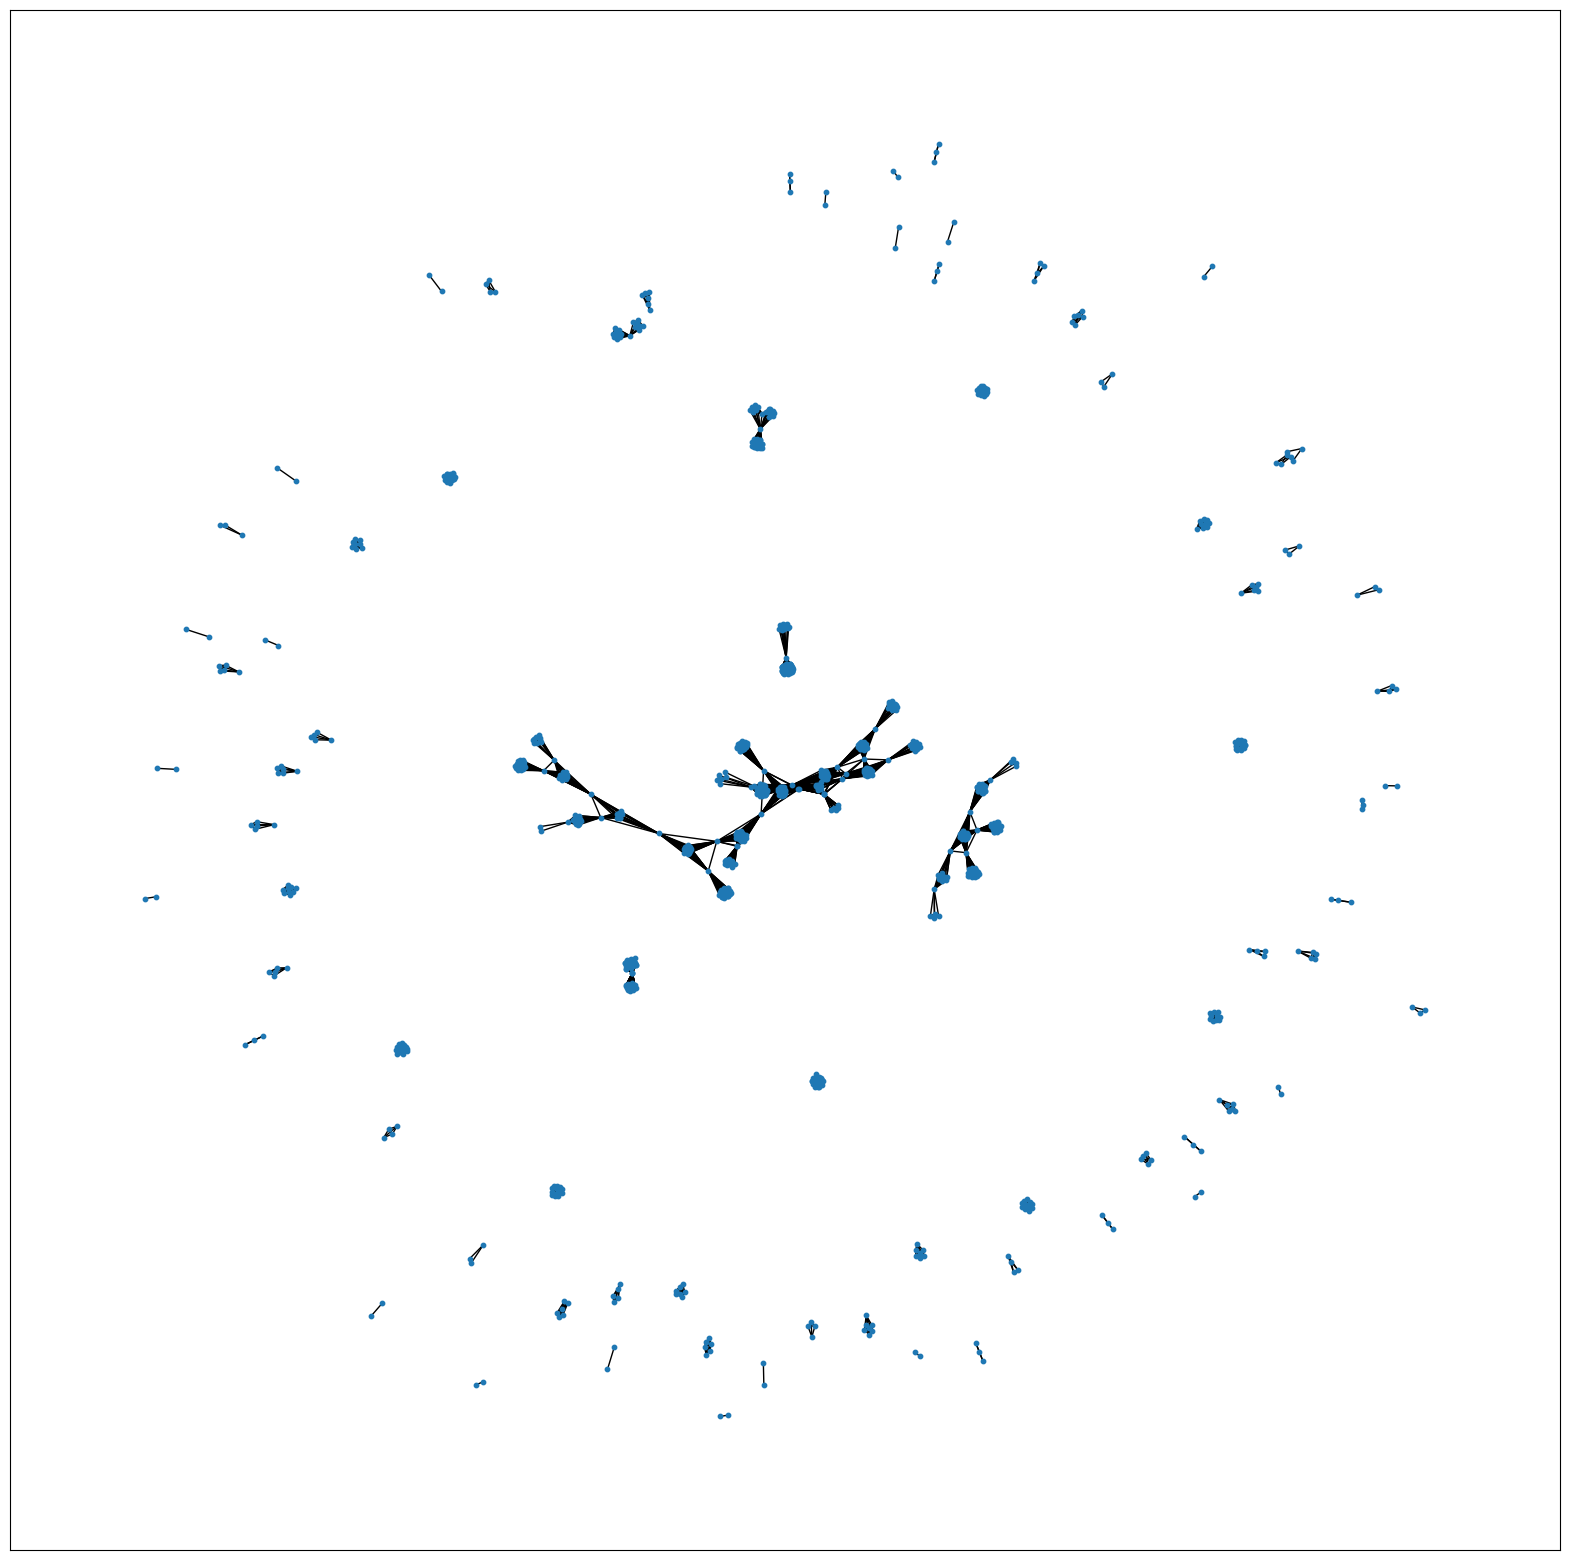

In [468]:
# Create a graph from the co_investment_counts DataFrame

G = nx.from_pandas_edgelist(co_investment_counts, 'name_x', 'name_y', ['CoInvestments'])

# Draw the graph
pos = nx.spring_layout(G)
#make the graph bigger
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos, with_labels=False, node_size=10, edge_color='black')
#add a heatmap
#nx.draw_networkx_edge_labels(G, pos, edge_labels=co_investment_counts['Distance'])

plt.show()


## **Descriptive Statistics** - 2

Descriptive Statistics on Angels

In [469]:
df_angel_descriptive = pd.DataFrame(columns=("variable","value"))

#Calulate total number of angels and add to df_angel_descriptive with variable name "total_number_of_angels"
total_number_of_angels = len(df_angels)
df_angel_descriptive.loc[0] = ["total_number_of_angels", total_number_of_angels]
#Calculate the amount of males among the angels
number_of_male_angels_total = len(df_angels[df_angels['gender'] == 'male'])
df_angel_descriptive.loc[1] = ["number_of_male_angels", number_of_male_angels_total]
#Calculate the amount of females among all angels
number_of_female_angels_total = len(df_angels[df_angels['gender'] == 'female'])
df_angel_descriptive.loc[2] = ["number_of_female_angels", number_of_female_angels_total]

#Calulate total number of active angels and add to df_angel_descriptive with variable name "total_number_of_active_angels"
total_number_of_active_angels = len(df_angels[df_angels['status'] == 'active'])
df_angel_descriptive.loc[3] = ["total_number_of_active_angels", total_number_of_active_angels]

#only consider active angels
df_angels = df_angels[df_angels['status'] == 'active']

#Calculate number of angels investing through a holding and add to df_angel_descriptive with variable name "number_of_angels_investing_through_a_holding"
number_of_angels_investing_through_a_holding = len(df_angels[df_angels['investment_entity'] == 'holding'])
# add them to df
df_angel_descriptive.loc[4] = ["number_of_angels_investing_through_a_holding", number_of_angels_investing_through_a_holding]

#Calculate number of angels investing as a person and add to df_angel_descriptive with variable name "number_of_angels_investing_as_a_person"
number_of_angels_investing_as_a_person = len(df_angels[df_angels['investment_entity'] == 'person'])
# add them to df
df_angel_descriptive.loc[5] = ["number_of_angels_investing_as_a_person", number_of_angels_investing_as_a_person]

#share of investments through holding and add to df_angel_descriptive with variable name "share_of_investments_through_holding"
share_of_investments_through_holding = number_of_angels_investing_through_a_holding/total_number_of_active_angels
# add them to df
df_angel_descriptive.loc[6] = ["share_of_investments_through_holding", share_of_investments_through_holding]

# calculate age based on birthdate and add to df_angel
df_angels['date_of_birth'] = pd.to_datetime(df_angels['date_of_birth'])
date = datetime(2021,12,31)
df_angels['age'] =((date - df_angels['date_of_birth']).dt.days)/365
#calculate mean age of angels and add to df_angel_descriptive with variable name "mean_age_of_angels"
mean_age_of_angels = df_angels['age'].mean()
# add them to df
df_angel_descriptive.loc[7] = ["mean_age_of_angels", mean_age_of_angels]

#Calculate the amount of males among the active angels
number_of_male_angels_active = len(df_angels[df_angels['gender'] == 'male'])
df_angel_descriptive.loc[8] = ["number_of_male_angels", number_of_male_angels_active]

#Calculate the amount of females among the active angels
number_of_female_angels_active = len(df_angels[df_angels['gender'] == 'female'])
df_angel_descriptive.loc[9] = ["number_of_female_angels", number_of_female_angels_active]

#Calculate average number of investment per active angel and add to df_angel_descriptive with variable name "average_number_of_investments_per_active_angel"
average_number_of_investments_per_active_angel = df_angels['number_of_investments'].mean()
# add them to df
df_angel_descriptive.loc[10] = ["average_number_of_investments_per_active_angel", average_number_of_investments_per_active_angel]

#Calculate median number of investment per active angel and add to df_angel_descriptive with variable name "median_number_of_investments_per_active_angel"
median_number_of_investments_per_active_angel = df_angels['number_of_investments'].median()
# add them to df
df_angel_descriptive.loc[11] = ["median_number_of_investments_per_active_angel", median_number_of_investments_per_active_angel]

#Calculate average inustry_HHI per active angel and add to df_angel_descriptive with variable name "average_inustry_HHI_per_active_angel"
average_inustry_HHI = df_angels['industry_HHI'].mean()
# add them to df
df_angel_descriptive.loc[12] = ["average_industry_HHI", average_inustry_HHI]

#Calculate average industry HHI across angels and add to df_angel_descriptive with variable name "average_industry_HHI_across_angels"
average_industry_HHI_across_angels = df_angels['industry_HHI_angel'].mean()
# add them to df
df_angel_descriptive.loc[13] = ["average_industry_HHI_across_angels", average_industry_HHI_across_angels]

#Calculate average eigenvector centrality across angels and add to df_angel_descriptive with variable name "average_eigenvector_centrality_across_angels"
average_eigenvector_centrality_across_angels = df_angels['eigenvector_centrality'].mean()
# add them to df
df_angel_descriptive.loc[14] = ["average_eigenvector_centrality_across_angels", average_eigenvector_centrality_across_angels]

df_angel_descriptive

,variable,value
0,total_number_of_angels,985.000000
1,number_of_male_angels,485.000000
2,number_of_female_angels,500.000000
3,total_number_of_active_angels,46.000000
4,number_of_angels_investing_through_a_holding,26.000000
5,number_of_angels_investing_as_a_person,20.000000
6,share_of_investments_through_holding,0.565217
7,mean_age_of_angels,45.446814
8,number_of_male_angels,19.000000
9,number_of_female_angels,27.000000


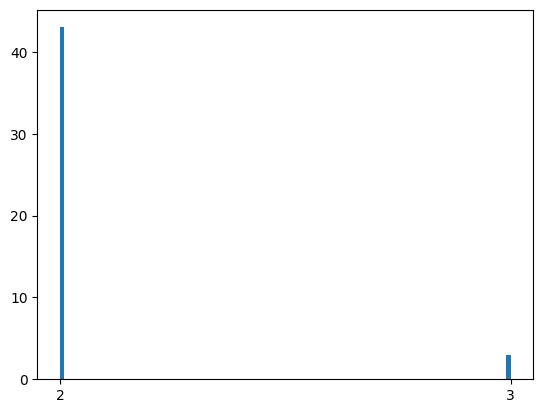

In [470]:
#Plot distribution of number of investments per angel
plt.hist(df_angels['number_of_investments'], bins=100)
# only plot whole numbers on x-axis
plt.xticks(np.arange(min(df_angels['number_of_investments']), max(df_angels['number_of_investments'])+1, 1.0))
#export to png as "Number of investments.png"
plt.savefig('graphs/Distribution of number of investments.png')


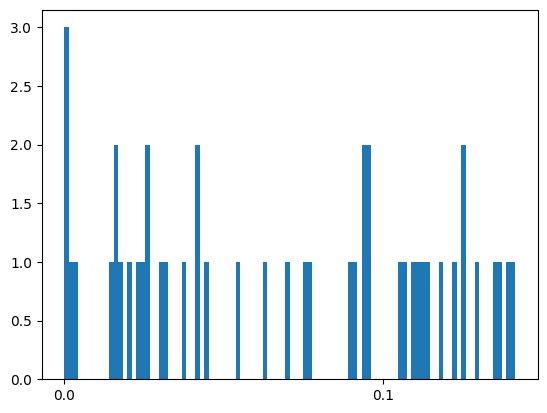

In [471]:
#plot distribution of average shares in their investments including decimals
plt.hist(df_angels['total_participation'], bins=100)
# plot also decimals on X-axis from 0 to 0.2
plt.xticks(np.arange(0, 0.2, 0.1))
#export to png as "Distribution of average shares of angels.png"
plt.savefig('graphs/Distribution of average shares of angels.png')


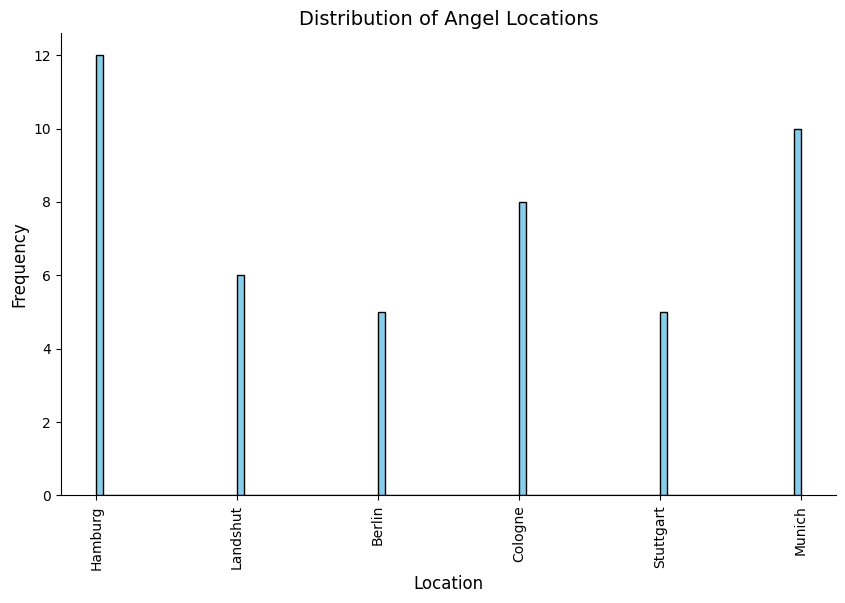

<Figure size 640x480 with 0 Axes>

In [472]:
import matplotlib.pyplot as plt

# Drop NaN values
data = df_angels['location'].dropna()

# Set the figure size
plt.figure(figsize=(10,6))

# Plot the histogram with a color
plt.hist(data, bins=100, color='skyblue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Angel Locations', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Remove top and right spines for aesthetics
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

#export graph as image called "Number of angels per region.png"
plt.savefig('graphs/Number of angels per region.png')

## Descriptive Statistics on Startups

In [473]:
# Calculate descriptive statistics for strtups from df_startups, add to df_startup_descriptive
# we want to calculate the following variables:
# total_number_of_startups
#average number of angel investors
#median number of angel investors
#average number of active angels
#median number of active angels

df_startup_descriptive = pd.DataFrame(columns=("variable","value"))

#Calulate total number of startups and add to df_startup_descriptive with variable name "total_number_of_startups"
total_number_of_startups = len(df_startups)
df_startup_descriptive.loc[0] = ["total_number_of_startups", total_number_of_startups]

#Calulate average number of angel investors and add to df_startup_descriptive with variable name "average_number_of_angel_investors"
average_number_of_angel_investors = df_startups['number_of_investors'].mean()
df_startup_descriptive.loc[1] = ["average_number_of_angel_investors", average_number_of_angel_investors]

#Calulate median number of angel investors and add to df_startup_descriptive with variable name "median_number_of_angel_investors"
median_number_of_angel_investors = df_startups['number_of_investors'].median()
df_startup_descriptive.loc[2] = ["median_number_of_angel_investors", median_number_of_angel_investors]

#Calulate average number of active angels and add to df_startup_descriptive with variable name "average_number_of_active_angels"
average_number_of_angels = df_startups['number_of_angels'].mean()
df_startup_descriptive.loc[3] = ["average_number_of_angels", average_number_of_angels]

#Calulate median number of active angels and add to df_startup_descriptive with variable name "median_number_of_active_angels"
median_number_of_angels = df_startups['number_of_angels'].median()
df_startup_descriptive.loc[4] = ["median_number_of_angels", median_number_of_angels]

#Calulate average number of active angels and add to df_startup_descriptive with variable name "average_number_of_active_angels"
average_number_of_active_angels = df_startups['number_of_active_angels'].mean()
df_startup_descriptive.loc[5] = ["average_number_of_active_angels", average_number_of_active_angels]

#Calulate median number of active angels and add to df_startup_descriptive with variable name "median_number_of_active_angels"
median_number_of_active_angels = df_startups['number_of_active_angels'].median()
df_startup_descriptive.loc[6] = ["median_number_of_active_angels", median_number_of_active_angels]


df_startup_descriptive



,variable,value
0,total_number_of_startups,135.000000
1,average_number_of_angel_investors,7.666667
2,median_number_of_angel_investors,4.000000
3,average_number_of_angels,2.037037
4,median_number_of_angels,2.000000
5,average_number_of_active_angels,2.081481
6,median_number_of_active_angels,2.000000


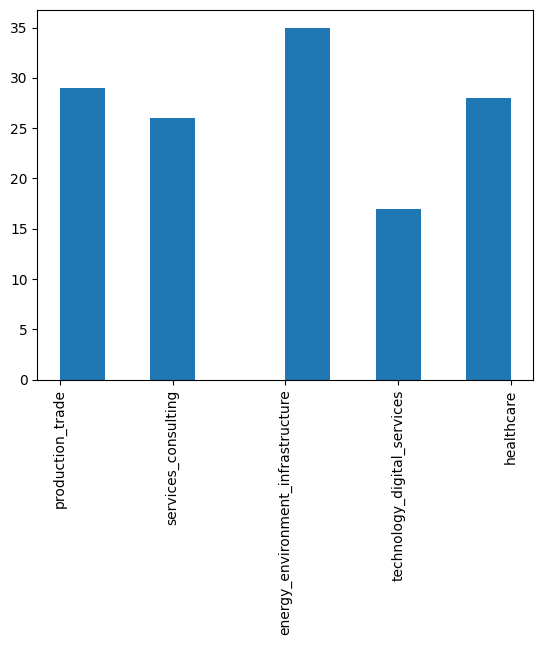

In [474]:
#Plot startups per industry
plt.hist(df_startups['industry'], bins=10)
#plot all industries
plt.xticks(rotation=90)

#export graph as image called "Number of Startups per Industry.png"
plt.savefig('graphs/Number of Startups per Industry.png')

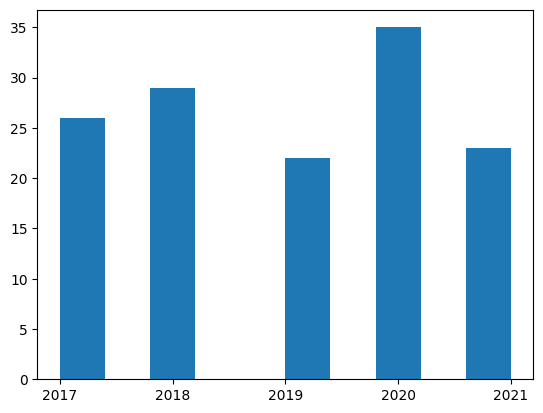

In [475]:
#Plot startups per year of incorporation
plt.hist(df_startups['year_of_incorporation'], bins=10)
#plot all years, make 1 year jumps, no decimals, make the bars thicker
plt.xticks(np.arange(min(df_startups['year_of_incorporation']), max(df_startups['year_of_incorporation'])+1, 1.0))

#export graph as image called "Number of Startups per Year of Incorporation.png"
plt.savefig('graphs/Number of Startups per Year of Incorporation.png')

## Network metrics



In [479]:
#Cosntruct a network graph of only the active angels
# get a list of co-investments

#only consider active angels in df_investment_rel_angel_startup
#match status from df_angels to df_investment_rel_angel_startup

# Create a new DataFrame where each row represents a co-investment
co_investments = df_investment_rel_angel_startup.merge(df_investment_rel_angel_startup, on='company')

# Filter out rows where the investor is the same in both columns
co_investments = co_investments[co_investments['name_x'] != co_investments['name_y']]

# # Create a table with the number of co-investments for each pair of investors
co_investment_counts = co_investments.groupby(['name_x', 'name_y']).size().reset_index(name='CoInvestments')

#replace all spaces with _ in name_x
co_investment_counts['name_x'] = co_investment_counts['name_x'].str.replace(' ', '_')
co_investment_counts['name_y'] = co_investment_counts['name_y'].str.replace(' ', '_')

#co_investment_counts.to_csv('co_investment_counts.csv', index=False)

#sort by number of co-investments
co_investment_counts = co_investment_counts.sort_values(by=['CoInvestments'], ascending=False)
print(co_investment_counts)


                                                  name_x  \
1850   Bayern_Kapital_Innovationsfonds_EFRE_GmbH_&_Co...   
12589                              Roskopf_Ventures_GmbH   
6910                         Herr_Vijay_Pravin_Maharajan   
7889                 K16-Boxwood_UG_(haftungsbeschrankt)   
13075                                     Saul_Tal_Levin   
...                                                  ...   
5516                               Fluss_des_Lebens_GmbH   
5517                               Fluss_des_Lebens_GmbH   
5518                               Fluss_des_Lebens_GmbH   
5519                               Fluss_des_Lebens_GmbH   
16545                    wrapall_UG_(haftungsbeschrankt)   

                                         name_y  CoInvestments  
1850   High-Tech_Griinderfonds_IV_GmbH_&_Co._KG              2  
12589                             Mercutio_GmbH              2  
6910                Herr_Saravanan_Jaichandaran              2  
7889               

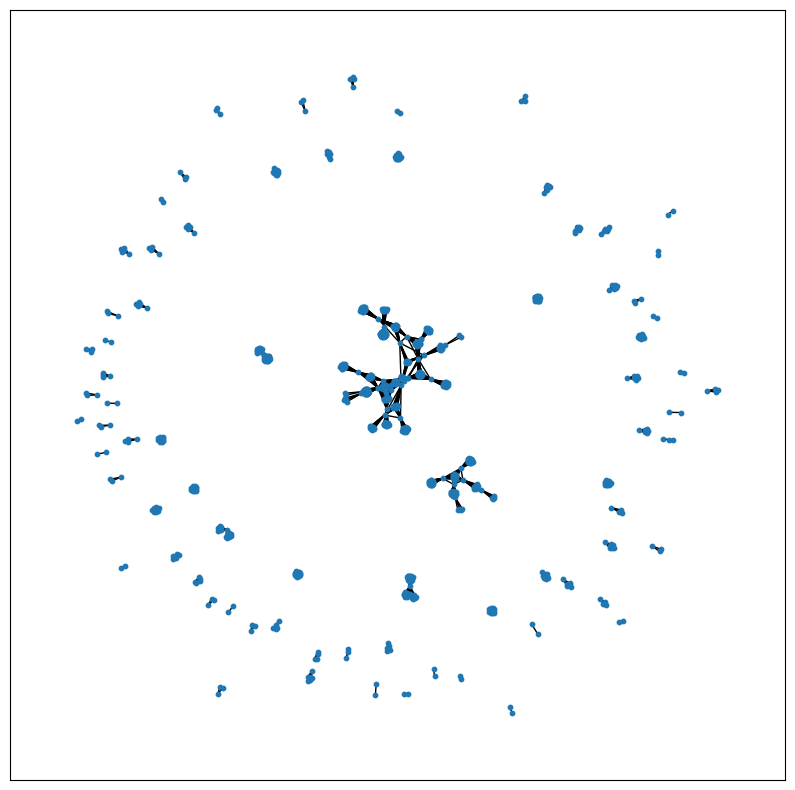

In [481]:
# Create a graph from the co_investment_counts DataFrame

G = nx.from_pandas_edgelist(co_investment_counts, 'name_x', 'name_y', ['CoInvestments'])

# Draw the graph
pos = nx.spring_layout(G)
#make the graph bigger
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos, with_labels=False, node_size=10, edge_color='black')
#add a heatmap
#nx.draw_networkx_edge_labels(G, pos, edge_labels=co_investment_counts['Distance'])

plt.show()


In [262]:
#Create a df_network_descrpiptive with the following variables:
#total_number_of_nodes
#total_number_of_edges
#average_degree
#median_degree
#average_clustering_coefficient
#median_clustering_coefficient
#average_shortest_path_length
#median_shortest_path_length
#average_eigenvector_centrality
#median_eigenvector_centrality
#average_betweenness_centrality
#median_betweenness_centrality
#average_closeness_centrality
#median_closeness_centrality
#average_pagerank
#median_pagerank

df_network_descriptive = pd.DataFrame(columns=("variable","value"))

#Calulate total number of nodes and add to df_network_descriptive with variable name "total_number_of_nodes"
total_number_of_nodes = len(G.nodes)
df_network_descriptive.loc[0] = ["total_number_of_nodes", total_number_of_nodes]

#Calulate total number of edges and add to df_network_descriptive with variable name "total_number_of_edges"
total_number_of_edges = len(G.edges)
df_network_descriptive.loc[1] = ["total_number_of_edges", total_number_of_edges]

#Calulate average degree and add to df_network_descriptive with variable name "average_degree"
average_degree = np.mean([G.degree(n) for n in G.nodes])
df_network_descriptive.loc[2] = ["average_degree", average_degree]

#Calulate median degree and add to df_network_descriptive with variable name "median_degree"
median_degree = np.median([G.degree(n) for n in G.nodes])
df_network_descriptive.loc[3] = ["median_degree", median_degree]

#Calulate average clustering coefficient and add to df_network_descriptive with variable name "average_clustering_coefficient"
average_clustering_coefficient = nx.average_clustering(G)
df_network_descriptive.loc[4] = ["average_clustering_coefficient", average_clustering_coefficient]

#Calulate median clustering coefficient and add to df_network_descriptive with variable name "median_clustering_coefficient"
median_clustering_coefficient = nx.average_clustering(G)
df_network_descriptive.loc[5] = ["median_clustering_coefficient", median_clustering_coefficient]


#Calulate average eigenvector centrality and add to df_network_descriptive with variable name "average_eigenvector_centrality"
average_eigenvector_centrality = np.mean([v for k,v in nx.eigenvector_centrality(G).items()])
df_network_descriptive.loc[8] = ["average_eigenvector_centrality", average_eigenvector_centrality]

#Calulate median eigenvector centrality and add to df_network_descriptive with variable name "median_eigenvector_centrality"
median_eigenvector_centrality = np.median([v for k,v in nx.eigenvector_centrality(G).items()])
df_network_descriptive.loc[9] = ["median_eigenvector_centrality", median_eigenvector_centrality]

#Calulate average betweenness centrality and add to df_network_descriptive with variable name "average_betweenness_centrality"
average_betweenness_centrality = np.mean([v for k,v in nx.betweenness_centrality(G).items()])
df_network_descriptive.loc[10] = ["average_betweenness_centrality", average_betweenness_centrality]

#Calulate median betweenness centrality and add to df_network_descriptive with variable name "median_betweenness_centrality"
median_betweenness_centrality = np.median([v for k,v in nx.betweenness_centrality(G).items()])
df_network_descriptive.loc[11] = ["median_betweenness_centrality", median_betweenness_centrality]

#Calulate average closeness centrality and add to df_network_descriptive with variable name "average_closeness_centrality"
average_closeness_centrality = np.mean([v for k,v in nx.closeness_centrality(G).items()])
df_network_descriptive.loc[12] = ["average_closeness_centrality", average_closeness_centrality]

#Calulate median closeness centrality and add to df_network_descriptive with variable name "median_closeness_centrality"
median_closeness_centrality = np.median([v for k,v in nx.closeness_centrality(G).items()])
df_network_descriptive.loc[13] = ["median_closeness_centrality", median_closeness_centrality]

#Calulate average pagerank and add to df_network_descriptive with variable name "average_pagerank"
average_pagerank = np.mean([v for k,v in nx.pagerank(G).items()])
df_network_descriptive.loc[14] = ["average_pagerank", average_pagerank]

#Calulate median pagerank and add to df_network_descriptive with variable name "median_pagerank"
median_pagerank = np.median([v for k,v in nx.pagerank(G).items()])
df_network_descriptive.loc[15] = ["median_pagerank", median_pagerank]

#Calculate average number of co-investments per angel and add to df_network_descriptive with variable name "average_number_of_co_investments_per_angel"
average_number_of_co_investments_per_angel = co_investment_counts['CoInvestments'].mean()
df_network_descriptive.loc[16] = ["average_number_of_co_investments_per_angel", average_number_of_co_investments_per_angel]


#Calculate median number of co-investments per angel and add to df_network_descriptive with variable name "median_number_of_co_investments_per_angel"
median_number_of_co_investments_per_angel = co_investment_counts['CoInvestments'].median()
df_network_descriptive.loc[17] = ["median_number_of_co_investments_per_angel", median_number_of_co_investments_per_angel]
#Calculate maximum number of co-investments
maximum_number_of_co_investments = co_investment_counts['CoInvestments'].max()
df_network_descriptive.loc[18] = ["maximum_number_of_co_investments", maximum_number_of_co_investments]


df_network_descriptive

,variable,value
0,total_number_of_nodes,42.000000
1,total_number_of_edges,91.000000
2,average_degree,4.333333
3,median_degree,4.000000
4,average_clustering_coefficient,0.723220
5,median_clustering_coefficient,0.723220
8,average_eigenvector_centrality,0.084189
9,median_eigenvector_centrality,0.000967
10,average_betweenness_centrality,0.020993
11,median_betweenness_centrality,0.000000


In [482]:
#check network for largest connected component
largest_cc = max(nx.connected_components(G), key=len)
import networkx as nx


# Calculate average shortest path length
avg_shortest_path_length = nx.average_shortest_path_length(largest_cc)
print(f"Average shortest path length: {avg_shortest_path_length}")

# Calculate average clustering coefficient
avg_clustering_coeff = nx.average_clustering(largest_cc)
print(f"Average clustering coefficient: {avg_clustering_coeff}")

import numpy as np
# Create a random graph with the same number of nodes and similar number of edges
random_graph = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

# Calculate metrics for the random graph
random_avg_shortest_path_length = nx.average_shortest_path_length(random_graph)
random_avg_clustering_coeff = nx.average_clustering(random_graph)

# Compare metrics
print(f"Is the original graph a small-world graph? {np.all([(avg_clustering_coeff > random_avg_clustering_coeff), (avg_shortest_path_length <= random_avg_shortest_path_length)])}")

AttributeError: 'set' object has no attribute 'is_directed'

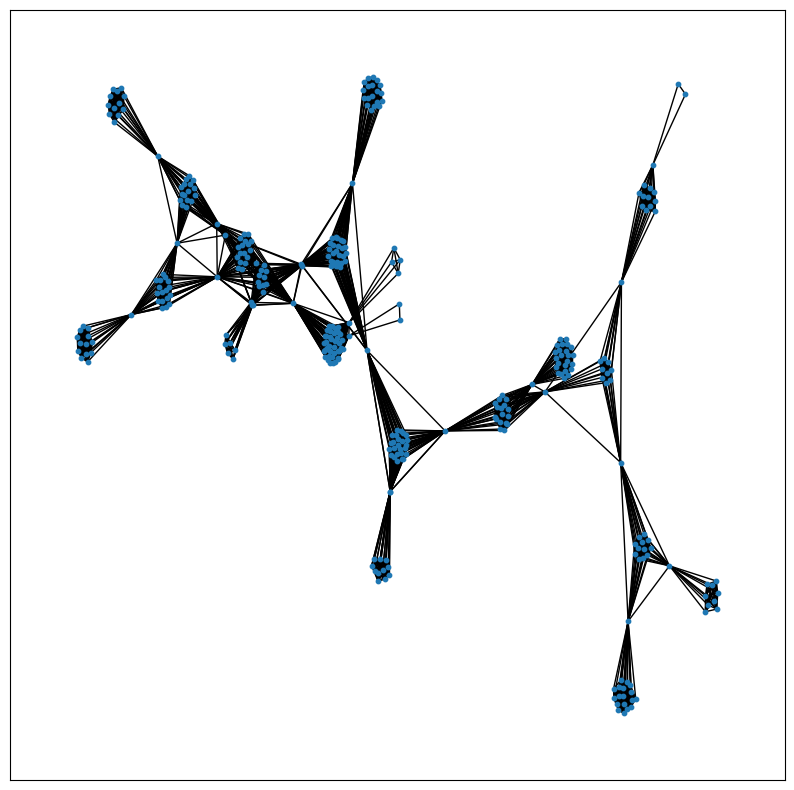

In [483]:
#plot largest subgraph
# Create a subgraph of the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc)

# Draw the subgraph
pos = nx.spring_layout(subgraph)
plt.figure(figsize=(10,10))
nx.draw_networkx(subgraph, pos, with_labels=False, node_size=10, edge_color='black')
plt.show()


## Simulating a network - 3



In [489]:
# Initialize an empty DataFrame to record the simulated investment relations
df_investment_rel_angel_startup_simulated = pd.DataFrame()

# Initialize a dictionary to keep track of the angels that have invested in each startup
angel_startup_map = {}

# Loop through each startup
for _, startup in df_startups.iterrows():
    x = 0
    # Initialize an empty list for each startup to keep track of its angels
    angel_startup_map[startup['company']] = []
    while x < startup['number_of_angels']:
        # Filter angels based on the criteria: active status, minimum 1 investment in the startup's industry, and same location as the startup
        eligible_angels = df_angels[(df_angels['status'] == "active") & 
                                     (df_angels[startup['industry']] >= 1) & 
                                     (df_angels[startup['location']+"_investments"] >= 1) &
                                     (~df_angels['name'].isin(angel_startup_map[startup['company']]))]
        
        # If there are eligible angels
        if not eligible_angels.empty:
            # Sample a random angel from the eligible angels
            sampled_angel = eligible_angels.sample(n=1)
        
            # Create a record of the investment relationship
            investment_record = pd.DataFrame({
                'company': [startup['company']],
                'angel': [sampled_angel.iloc[0]['name']],  # Assuming df_angels has a 'name' column
                'industry': [startup['industry']],  # Assuming df_startups has an 'industry' column
                'region': [sampled_angel.iloc[0]['location']],  # Assuming df_angels has a 'location' column
                'total_participation_in_percent': [sampled_angel.iloc[0]['total_participation']],  # Assuming df_angels has a 'total_participation' column
                'date_of_birth': [sampled_angel.iloc[0]['date_of_birth']]  # Assuming df_angels has a 'date_of_birth' column
            })
            
            # Append the record to the df_investment_rel_angel_startup DataFrame
            df_investment_rel_angel_startup_simulated = df_investment_rel_angel_startup_simulated.append(investment_record, ignore_index=True)
            
            # Add the angel to the list of drawn angels for the startup
            angel_startup_map[startup['company']].append(sampled_angel.iloc[0]['name'])
            
            x += 1
        else:
            # If no eligible angel is left, relax the location criterion and take an angel that fulfills all criteria except location
            eligible_angels = df_angels[(df_angels['status'] == "active") & 
                                     (df_angels[startup['industry']] >= 1) &
                                     (~df_angels['name'].isin(angel_startup_map[startup['company']]))]
            if not eligible_angels.empty:
                # Sample a random angel from the eligible angels
                sampled_angel = eligible_angels.sample(n=1)
        
                # Create a record of the investment relationship
                investment_record = pd.DataFrame({
                    'company': [startup['company']],
                    'angel': [sampled_angel.iloc[0]['name']],
                    'industry': [startup['industry']],
                    'region': [sampled_angel.iloc[0]['location']],
                    'total_participation_in_percent': [sampled_angel.iloc[0]['total_participation']],
                    'date_of_birth': [sampled_angel.iloc[0]['date_of_birth']]
                })
            
                # Append the record to the df_investment_rel_angel_startup DataFrame
                df_investment_rel_angel_startup_simulated = df_investment_rel_angel_startup_simulated.append(investment_record, ignore_index=True)
            
                # Add the angel to the list of drawn angels for the startup
                angel_startup_map[startup['company']].append(sampled_angel.iloc[0]['name'])
            
                x += 1
            else:
                # If no eligible angel is still left, take any active and eligible angel regardless of industry
                eligible_angels = df_angels[(df_angels['status'] == "active") & 
                                     (~df_angels['name'].isin(angel_startup_map[startup['company']]))]
                if not eligible_angels.empty:
                    # Sample a random angel from the eligible angels
                    sampled_angel = eligible_angels.sample(n=1)
        
                    # Create a record of the investment relationship
                    investment_record = pd.DataFrame({
                        'company': [startup['company']],
                        'angel': [sampled_angel.iloc[0]['name']],
                        'industry': [startup['industry']],
                        'region': [sampled_angel.iloc[0]['location']],
                        'total_participation_in_percent': [sampled_angel.iloc[0]['total_participation']],
                        'date_of_birth': [sampled_angel.iloc[0]['date_of_birth']]
                    })
            
                    # Append the record to the df_investment_rel_angel_startup DataFrame
                    df_investment_rel_angel_startup_simulated = df_investment_rel_angel_startup_simulated.append(investment_record, ignore_index=True)
            
                    # Add the angel to the list of drawn angels for the startup
                    angel_startup_map[startup['company']].append(sampled_angel.iloc[0]['name'])
            
                    x += 1
                else:
                    break

/var/folders/nw/rzxfctl55nj95y0twwbqxrm40000gn/T/ipykernel_21599/1180626864.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_investment_rel_angel_startup_simulated = df_investment_rel_angel_startup_simulated.append(investment_record, ignore_index=True)
/var/folders/nw/rzxfctl55nj95y0twwbqxrm40000gn/T/ipykernel_21599/1180626864.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_investment_rel_angel_startup_simulated = df_investment_rel_angel_startup_simulated.append(investment_record, ignore_index=True)
/var/folders/nw/rzxfctl55nj95y0twwbqxrm40000gn/T/ipykernel_21599/1180626864.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_investment_rel_angel_startup_simulated = df_investment_rel_angel_startup_simulate

In [485]:
#calculate total sum of angel investors
total_number_of_angel_investors = len(df_investment_rel_angel_startup_simulated)
print(total_number_of_angel_investors)

279


In [487]:
#create a network graph from the simulated data
# Create a new DataFrame where each row represents a co-investment
co_investments_simulated = df_investment_rel_angel_startup_simulated.merge(df_investment_rel_angel_startup_simulated, on='company')

# Filter out rows where the investor is the same in both columns
co_investments_simulated = co_investments_simulated[co_investments_simulated['angel_x'] != co_investments_simulated['angel_y']]
# # Create a table with the number of co-investments for each pair of investors
co_investment_counts_simulated = co_investments_simulated.groupby(['angel_x', 'angel_y']).size().reset_index(name='CoInvestments')

#replace all spaces with _ in name_x
co_investment_counts_simulated['angel_x'] = co_investment_counts_simulated['angel_x'].str.replace(' ', '_')
co_investment_counts_simulated['angel_y'] = co_investment_counts_simulated['angel_y'].str.replace(' ', '_')

co_investment_counts_simulated.to_csv('co_investment_counts_simulated.csv', index=False)

#sort by number of co-investments
co_investment_counts_simulated = co_investment_counts_simulated.sort_values(by=['CoInvestments'], ascending=False)
print(co_investment_counts_simulated)




                                      angel_x  \
72                              Mercutio_GmbH   
60                              La_Plata_GmbH   
37         Companisto_Trust_Service_XVII_GmbH   
42                          DSR_Ventures_GmbH   
99                 Vesta_Venture_Holding_GmbH   
..                                        ...   
41                          DSR_Ventures_GmbH   
40                          DSR_Ventures_GmbH   
39         Companisto_Trust_Service_XVII_GmbH   
34                          Charles_Songhurst   
109  eNugget_Ventures_UG_(haftungsbeschrankt)   

                                               angel_y  CoInvestments  
72                                       La_Plata_GmbH              8  
60                                       Mercutio_GmbH              8  
37                                   DSR_Ventures_GmbH              6  
42                  Companisto_Trust_Service_XVII_GmbH              6  
99   Bayern_Kapital_Innovationsfonds_EFRE_GmbH_&_Co

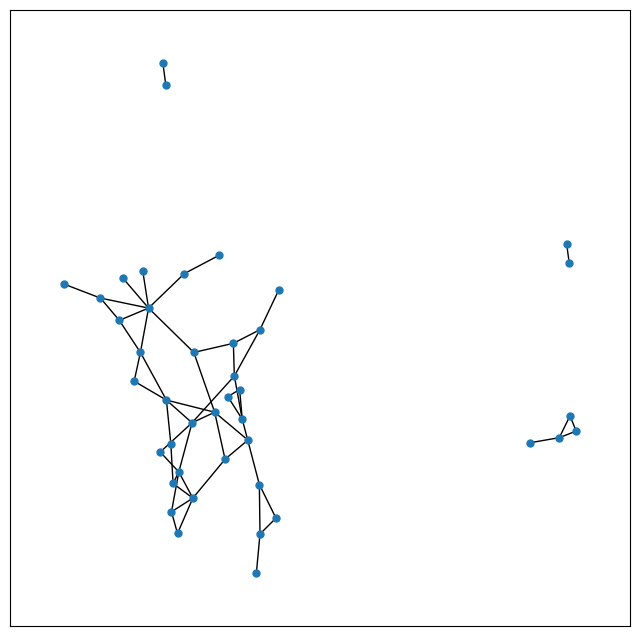

In [498]:
#plot network graph of simulated data
# Create a graph from the co_investment_counts DataFrame

G_simulated = nx.from_pandas_edgelist(co_investment_counts_simulated, 'angel_x', 'angel_y', ['CoInvestments'])

# Draw the graph
pos = nx.spring_layout(G_simulated)
#make the graph bigger
plt.figure(figsize=(8,8))
nx.draw_networkx(G_simulated, pos, with_labels=False, node_size=25, edge_color='black')
#add a heatmap
#nx.draw_networkx_edge_labels(G, pos, edge_labels=co_investment_counts['Distance'])
#save graph as png
plt.savefig('graphs/Simulated Network Graph.png')
plt.show()



In [415]:
df_investment_rel_angel_startup

,company,name,registry_details,location,nominal_value_per_share,total_nominal_value,total_participation_in_percent,date_of_birth,participation_per_share,Unnamed: 9,startup_location,status_x,industry,status_y
0,Penzilla GmbH,CCL Capital UG 50,001 ‚Äî 100,000/ (haftungsbeschr,NaN,NaN,1.0,50000.0,NaN,Penzilla GmbH,Landshut,NaN,services_consulting,NaN
1,Urbyo GmbH_Berlin (Charlottenburg),Fund I,a series (legally segregated fund under Delaw...,LP,AG Secretary of the state of Delaware 5964568 ...,Delaware,1.0,240.0,NaN,Urbyo GmbH_Berlin (Charlottenburg),Hamburg,NaN,technology_digital_services,NaN
2,Mondu GmbH_Berlin (Charlottenburg),Fund I,a series of Nomad Capital VC,LP,NaN,NaN,1.0,46.0,NaN,Mondu GmbH_Berlin (Charlottenburg),Stuttgart,NaN,production_trade,NaN
3,Edurino,FJ Labs Entrepreneurs Fund 2022,eine Serie von FJ Labs Funds,LP,6551354,NaN,NaN,15.0,NaN,Edurino,Munich,NaN,services_consulting,NaN
4,Friday Finance GmbH_Berlin (Charlottenburg),Tiny Fund Il,a series of Tiny Supercomputer Investment Com...,LP,Secretary of State of Delaware Nr. 6912454,NaN,1.0,175.0,NaN,Friday Finance GmbH_Berlin (Charlottenburg),Hamburg,NaN,production_trade,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,NaN,Creandum V,L.P,Guernsey Registry 3198,NaN,100.0,41248.0,6.074.317.074.851.180,Yababa GmbH_Berlin (Charlottenburg),NaN,Cologne,NaN,NaN,NaN
1031,NaN,Storm Ventures Fund VI,L.P.,Secretary of State of the State of Delaware un...,NaN,1.0,4698.0,30.608.339.487.057.800,Circula GmbH_Berlin (Charlottenburg),NaN,Cologne,NaN,NaN,NaN
1032,NaN,Equinix,Inc.,Nr. 4179809,NaN,1500.0,1500.0,16.729.966.383.584.100,Upminster GmbH_Frankfurt am Main,6 %,Hamburg,NaN,NaN,NaN
1033,NaN,Scout VI-A,LLC,Secretary of State of Delaware Nr. 5284974,NaN,1.0,65.0,4.784.651.224.890.540,Friday Finance GmbH_Berlin (Charlottenburg),NaN,Stuttgart,NaN,NaN,NaN


In [442]:
#Draw a network graph of active angels only
# Create a new DataFrame where each row represents a co-investment

#only consider active angels in df_investment_rel_angel_startup
#match status from df_angels to df_investment_rel_angel_startup
#df_investment_rel_angel_startup = df_investment_rel_angel_startup.merge(df_angels[['name','status']], left_on='name', right_on='name', how='left')
#only consider active angels
df_investment_rel_angel_startup_active = df_investment_rel_angel_startup[df_investment_rel_angel_startup['status'] == 'active']

co_investments_active = df_investment_rel_angel_startup_active.merge(df_investment_rel_angel_startup_active, on='company')

# Filter out rows where the investor is the same in both columns
co_investments_active = co_investments_active[co_investments_active['name_x'] != co_investments_active['name_y']]
# # Create a table with the number of co-investments for each pair of investors
co_investment_counts_active = co_investments_active.groupby(['name_x', 'name_y']).size().reset_index(name='CoInvestments')

#replace all spaces with _ in name_x
co_investment_counts_active['name_x'] = co_investment_counts_active['name_x'].str.replace(' ', '_')
co_investment_counts_active['name_y'] = co_investment_counts_active['name_y'].str.replace(' ', '_')

co_investment_counts_active.to_csv('co_investment_counts_active.csv', index=False)

#sort by number of co-investments
co_investment_counts_active = co_investment_counts_active.sort_values(by=['CoInvestments'], ascending=False)
print(co_investment_counts_active)

                                       name_x  \
91                                  Lino_GmbH   
52      Entrepreneur_First_Operations_Limited   
68                Herr_Saravanan_Jaichandaran   
35         Companisto_Trust_Service_XVII_GmbH   
36         Companisto_Trust_Service_XVII_GmbH   
..                                        ...   
80                              La_Plata_GmbH   
82                              La_Plata_GmbH   
83                              La_Plata_GmbH   
84                              La_Plata_GmbH   
181  eNugget_Ventures_UG_(haftungsbeschrankt)   

                                         name_y  CoInvestments  
91                             PK_Projects_GmbH              2  
52     eNugget_Ventures_UG_(haftungsbeschrankt)              2  
68                      Herr_Ashok_Varadharajan              2  
35   Alexander_Ludwig_Friedrich_Christian_Fuchs              2  
36            Dr._Alfred_Heinrich_Georg_Spieker              2  
..                   

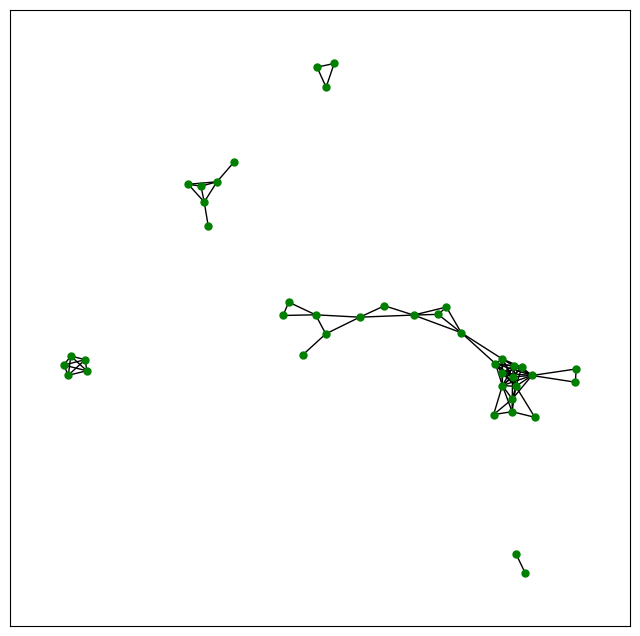

In [495]:
#plot network graph of active angels only
# Create a graph from the co_investment_counts DataFrame

G_active = nx.from_pandas_edgelist(co_investment_counts_active, 'name_x', 'name_y', ['CoInvestments'])

# Draw the graph
pos = nx.spring_layout(G_active)
#make the graph bigger
plt.figure(figsize=(8,8))
# make nodes bigger in the graph
nx.draw_networkx(G_active, pos, with_labels=False, node_size=25, edge_color='black', node_color='green')

#Save graph as png
plt.savefig('graphs/Active Angels Network Graph.png')

## Detecting communities - 4



In [ ]:
# Was nutzen wir (angelehnt an bubna, aber deren walk trap ausgetaischt mit apparently more robus leiden algorithmus) considered
# - Leiden (von louvain zu Leiden)
# - minimum 5 community members
# - diameter of the community not larger than 1/4 of the diameter of the largest connected subgraph

## Analysis of similarity within communities - 5


In [3]:
def calculate_hhi(market_shares):
    """
    Calculate Herfindahl-Hirschmann Index (HHI)
    
    Parameters:
    market_shares (list): List of market shares for each company
    
    Returns:
    hhi (float): Calculated HHI index
    """
    hhi = sum([share**2 for share in market_shares])
    hhi=hhi/10000
    return hhi

# Example usage:
market_shares = [30, 30, 20, 20]  # Market shares in percent
hhi = calculate_hhi(market_shares)
print(f"The HHI is {hhi}")

The HHI is 0.26
